In [1]:
import pandas_datareader as web
import pandas as pd
import numpy as np

In [2]:
def download_daily_data(symbol, start, end):
    """
    The function download daily stock data from Yahoo finance to pandas Dataframe 
    using Pandas_datareader module https://pandas-datareader.readthedocs.io/en/latest/
    between the dates specified.
    """
    try: 
        df = web.DataReader(symbol,"yahoo", start, end)
        print(f"Data for symbol {symbol} was downloaded sucessfully!")
    except:
        print(f"There is some error for symbol {symbol} with data download")
        
    return df
    
def compute_daily_returns(data):
    """
    The function computes daily log returns based on the Close prices in the pandas
    DataFrame and stores it in column cc_returns.
    """
    data["cc_returns"] = np.log(data["Close"] / data["Close"].shift(1))
    return data


def compute_indicators(data, zscore_lookback):
    """
    The function calculates Z_Score indicator for specified lookback.
    """  
    # Compute z score indicator
    data["mean"] = data["Close"].rolling(window = zscore_lookback).mean() 
    data["stdev"] = data["Close"].rolling(window = zscore_lookback).std()
    data["z_score"] = ( data["Close"] - data["mean"]) / data["stdev"]
    data["z_score_signal"] = data["z_score"].rolling(window = 5).mean()

    return data
    
def backtest_strategy(data):
    """
    The function computes additional columns in the pandas DataFrame 
    for checking conditions to backtest the "Z Score" trading strategy.
    It computes the strategy returns then
    """
    data["condition1"] = np.where( (data["z_score"] < -1.5)
                                  & (data["Close"] < data["Open"].shift(1)),
                                  1, 0)
     
    # All three conditions above are True
    valid_signal = data["condition1"]==1 
    # Place Trading signal                           
    data["signal"] = np.where(valid_signal,1,0)

    # Calculate correctly positions and strategy returns
    # Shift "impulse" trading signal to next bar -> trade entry 1 bar after signal
    data["signal"] = data["signal"].shift(1)

    # Convert "impulse signal to "state" signal: 1== IN Position, 0== FLAT Position, holding period = 3 bars
    data["position"] = data["signal"].replace(to_replace=0, method="ffill", limit=5)

    # Calculate strategy returns
    data["strategy_returns"] = data["cc_returns"] * data["position"]

    return data

def show_backtesting_results(data):
    """
    The function displays the cummulative returns from trading strategy and buy&hold strategy.
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run only after the function backtest_strategy!!
    """    
    print("Buy & Hold Returns: ",np.round(data["cc_returns"].cumsum()[-1],2))
    print("Strategy Returns: ",np.round(data["strategy_returns"].cumsum()[-1],2))
    
    data[["cc_returns","strategy_returns"]] = data[["cc_returns","strategy_returns"]].cumsum()
    data[["cc_returns","strategy_returns","position"]].plot(secondary_y="position", grid = True, figsize=(12,8)) 

In [3]:
ticker = download_daily_data("SPY", "1/1/2005", "1/1/2021")

Data for symbol SPY was downloaded sucessfully!


In [4]:
df = compute_daily_returns(ticker)

In [5]:
df = compute_indicators(df, zscore_lookback=10 )

In [6]:
df = backtest_strategy(df)

Buy & Hold Returns:  1.13
Strategy Returns:  1.35


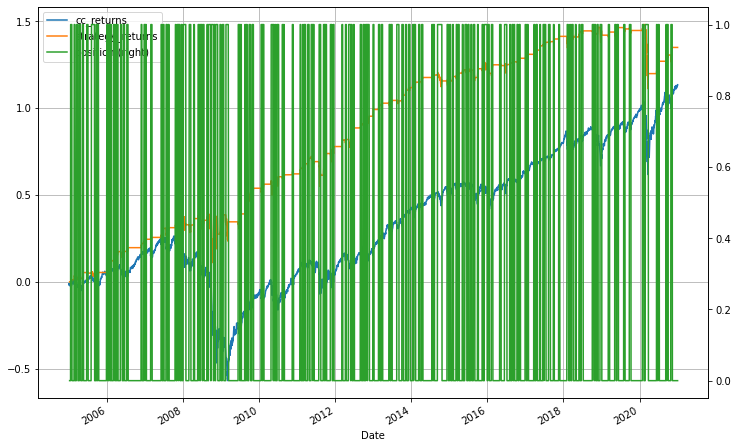

In [7]:
show_backtesting_results(df)

<AxesSubplot:xlabel='Date'>

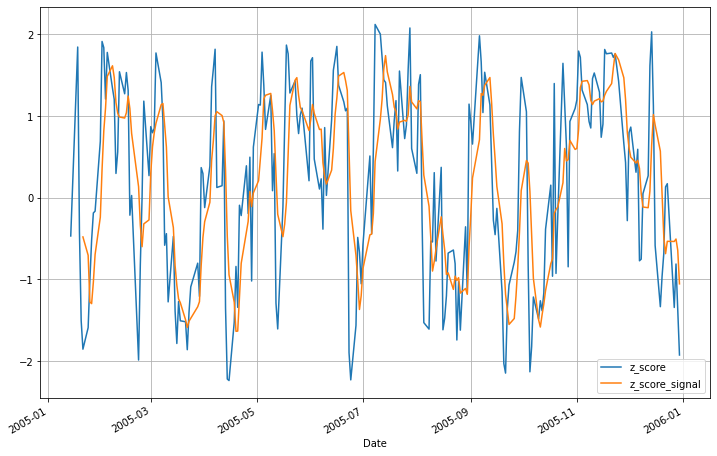

In [8]:
df[["z_score","z_score_signal" ]][0:252].plot(secondary_y="Close",grid=True,figsize = (12,8))